# Nhập dữ liệu

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import chi2_contingency

import sys
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import chi2,f_classif, mutual_info_classif, SelectKBest
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import lightgbm as lgb
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import RobustScaler
from imblearn.combine import SMOTEENN
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.naive_bayes import ComplementNB, GaussianNB, MultinomialNB

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Nhóm 3/Bài tập trên lớp/Báo cáo tiến trình/Project/cuoi_cung_ne.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35849 entries, 0 to 35848
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mssv          35849 non-null  object 
 1   gioitinh      35849 non-null  int64  
 2   khoahoc       35849 non-null  int64  
 3   chuyennganh2  35849 non-null  object 
 4   hedt_ CLC     35849 non-null  bool   
 5   hedt_ CNTN    35849 non-null  bool   
 6   hedt_ CQUI    35849 non-null  bool   
 7   hedt_ CTTT    35849 non-null  bool   
 8   hedt_ KSTN    35849 non-null  bool   
 9   khoa_ CNPM    35849 non-null  bool   
 10  khoa_ HTTT    35849 non-null  bool   
 11  khoa_ KHMT    35849 non-null  bool   
 12  khoa_ KTMT    35849 non-null  bool   
 13  khoa_ KTTT    35849 non-null  bool   
 14  khoa_ MMT&TT  35849 non-null  bool   
 15  khuvuc        35849 non-null  int64  
 16  xl_av         25323 non-null  float64
 17  xeploai_tt    35849 non-null  int64  
 18  hocky         35849 non-nu

In [6]:
#Chuyển về thuộc tính đầu ra
def danh_gia_diem(score):
    if score < 5:
        return 0
    elif 5 <= score < 6.5:
        return 1
    elif 6.5 <= score < 8:
        return 2
    elif 8 <= score < 9:
        return 3
    else:
        return 4

df['xeploai'] = df['dtbhk'].apply(danh_gia_diem)

print(df['dtbhk'])

0        9.00
1        9.11
2        8.75
3        8.54
4        8.74
         ... 
35844    7.89
35845    7.26
35846    7.88
35847    7.10
35848    8.70
Name: dtbhk, Length: 35849, dtype: float64


In [7]:
#Xóa đi cột cũ
df.drop(['dtbhk'], axis = 1, inplace = True)

## Mã hóa thuộc tính

In [8]:
label_encoder = LabelEncoder()
df.loc[:, 'mssv_encoded'] = label_encoder.fit_transform(df['mssv'])
df.drop(['mssv'], axis = 1, inplace = True)

In [9]:
# Bước 1: Mã hóa nhãn cho 'khuvuc' bằng Label Encoder và các thuộc tính khác bằng Ordinal Encoder
ordinal_features = [feature for feature in ['hedt_', 'khoa_', 'chuyennganh2'] if feature in df.columns]
# Mã hóa 'khuvuc' bằng Label Encoder
df['khuvuc_encoded'] = label_encoder.fit_transform(df['khuvuc'])

# Mã hóa 'xeploai_tt' và các thuộc tính khác bằng Ordinal Encoder
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
for feature in ordinal_features:
    df[feature + '_encoded'] = ordinal_encoder.fit_transform(df[[feature]])[:, 0]


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35849 entries, 0 to 35848
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   gioitinh              35849 non-null  int64  
 1   khoahoc               35849 non-null  int64  
 2   chuyennganh2          35849 non-null  object 
 3   hedt_ CLC             35849 non-null  bool   
 4   hedt_ CNTN            35849 non-null  bool   
 5   hedt_ CQUI            35849 non-null  bool   
 6   hedt_ CTTT            35849 non-null  bool   
 7   hedt_ KSTN            35849 non-null  bool   
 8   khoa_ CNPM            35849 non-null  bool   
 9   khoa_ HTTT            35849 non-null  bool   
 10  khoa_ KHMT            35849 non-null  bool   
 11  khoa_ KTMT            35849 non-null  bool   
 12  khoa_ KTTT            35849 non-null  bool   
 13  khoa_ MMT&TT          35849 non-null  bool   
 14  khuvuc                35849 non-null  int64  
 15  xl_av              

Gộp các thuộc tính lại

In [11]:
def determine_khoa(row):
    for col in row.index:
        if 'khoa_' in col and row[col] == True:
            return col.replace('khoa_', '').strip()
    return 'Other'

In [12]:
def determine_hedt(row):
    if row['hedt_ CLC']:
        return 'CLC'
    elif row['hedt_ CNTN']:
        return 'CNTN'
    elif row['hedt_ CQUI']:
        return 'CQUI'
    elif row['hedt_ CTTT']:
        return 'CTTT'
    else:
        return 'Other'

In [13]:
df['hedt'] = df.apply(determine_hedt, axis=1)

In [14]:
df['khoa'] = df.apply(determine_khoa, axis=1)

# Phân tích đơn biến

In [15]:
df.loc[:, 'hedt_encoded'] = label_encoder.fit_transform(df['hedt'])
df.loc[:, 'khoa_encoded'] = label_encoder.fit_transform(df['khoa'])

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35849 entries, 0 to 35848
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   gioitinh              35849 non-null  int64  
 1   khoahoc               35849 non-null  int64  
 2   chuyennganh2          35849 non-null  object 
 3   hedt_ CLC             35849 non-null  bool   
 4   hedt_ CNTN            35849 non-null  bool   
 5   hedt_ CQUI            35849 non-null  bool   
 6   hedt_ CTTT            35849 non-null  bool   
 7   hedt_ KSTN            35849 non-null  bool   
 8   khoa_ CNPM            35849 non-null  bool   
 9   khoa_ HTTT            35849 non-null  bool   
 10  khoa_ KHMT            35849 non-null  bool   
 11  khoa_ KTMT            35849 non-null  bool   
 12  khoa_ KTTT            35849 non-null  bool   
 13  khoa_ MMT&TT          35849 non-null  bool   
 14  khuvuc                35849 non-null  int64  
 15  xl_av              

In [17]:
df.columns

Index(['gioitinh', 'khoahoc', 'chuyennganh2', 'hedt_ CLC', 'hedt_ CNTN',
       'hedt_ CQUI', 'hedt_ CTTT', 'hedt_ KSTN', 'khoa_ CNPM', 'khoa_ HTTT',
       'khoa_ KHMT', 'khoa_ KTMT', 'khoa_ KTTT', 'khoa_ MMT&TT', 'khuvuc',
       'xl_av', 'xeploai_tt', 'hocky', 'namhoc', 'drltl', 'sotchk',
       'dtbhk_truoc', 'namnhaphoc', 'xeploai', 'mssv_encoded',
       'khuvuc_encoded', 'chuyennganh2_encoded', 'hedt', 'khoa',
       'hedt_encoded', 'khoa_encoded'],
      dtype='object')

Xác định các thuộc tính phân tích

In [18]:
discrete_vars = ['gioitinh', 'khoahoc', 'chuyennganh2', 'hedt', 'khoa','khuvuc', 'xl_av', 'xeploai_tt', 'hocky', 'namhoc', 'xeploai'       ]

continous_vars = ['drltl', 'sotchk', 'dtbhk_truoc']

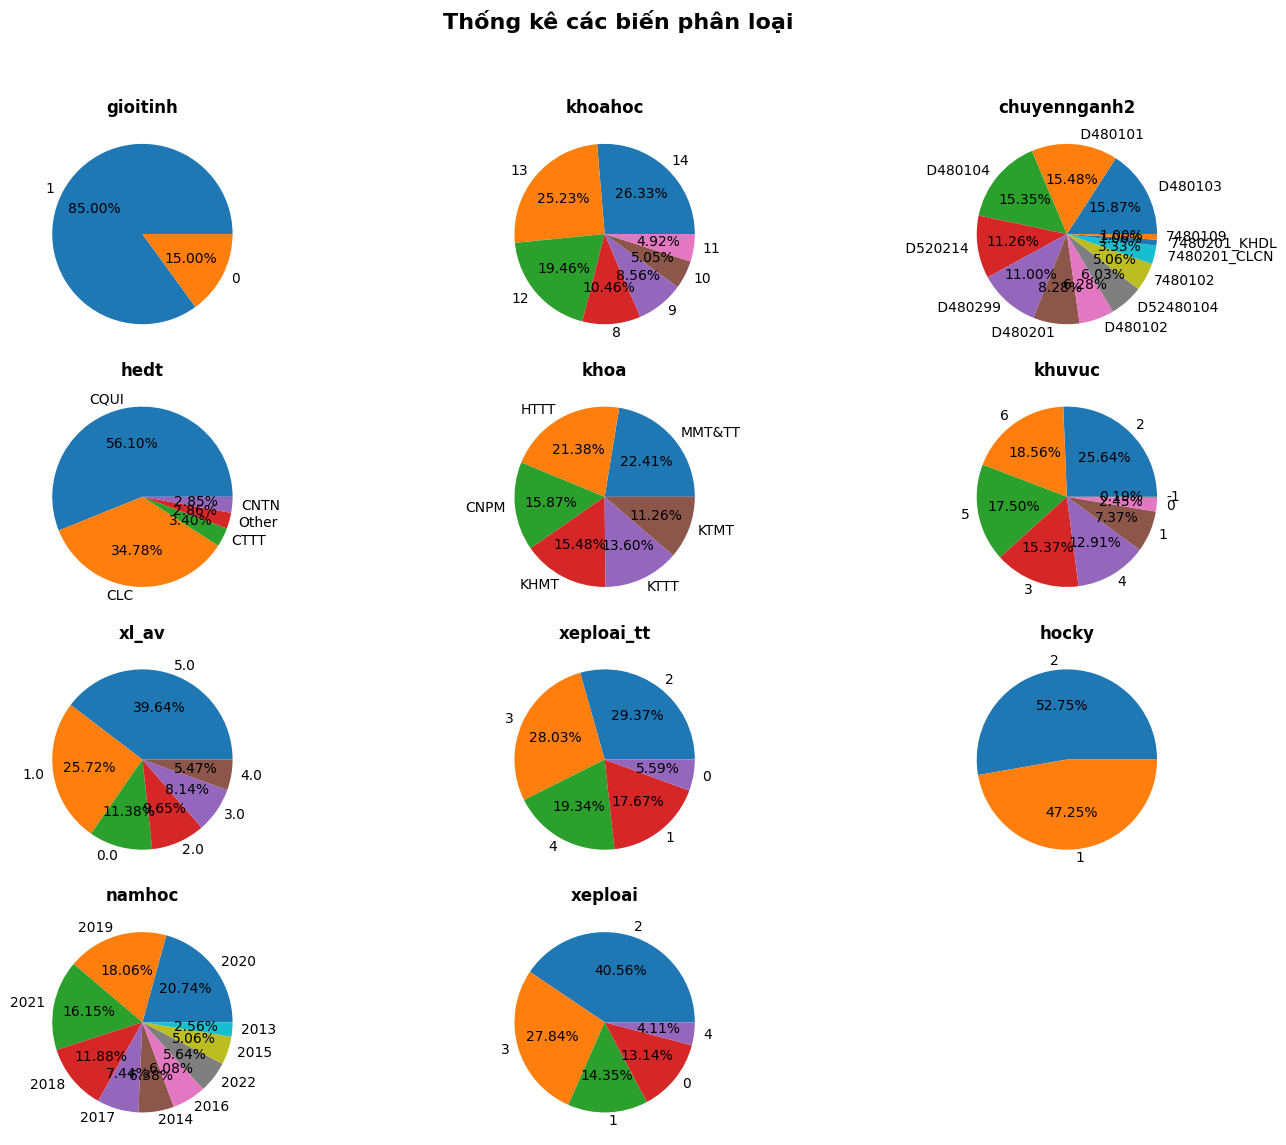

In [19]:
def discrete_plots(df, discrete_vars, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 12))
    fig.suptitle("Thống kê các biến phân loại", fontsize=16, weight='bold')

    for i, col in enumerate(discrete_vars):
        row = i // cols
        col_index = i % cols
        ax = axes[row, col_index]

        count = df[col].value_counts()
        ax.pie(count, labels=count.index, autopct='%.2f%%', radius=1)
        ax.set_title(f"{col}", fontsize=12, weight='bold')

    for j in range(i + 1, rows * cols):
        fig.delaxes(axes[j // cols, j % cols])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

discrete_plots(df, discrete_vars, rows=4, cols=3)


## Nhận xét 1
- Giới tính (gioitinh):
Biểu đồ cho thấy phần lớn dữ liệu thuộc về một giới tính (87.67% là một giới tính cụ thể), trong khi giới tính còn lại chiếm 12.33%. Điều này có thể gợi ý sự mất cân bằng giới tính trong tập dữ liệu hoặc trong đối tượng khảo sát.
- Khóa học (khoahoc):
Các khóa học được phân bổ khá đồng đều với một số khóa học chiếm tỷ lệ cao hơn một chút. Điều này cho thấy sự đa dạng trong việc chọn lựa khóa học của các sinh viên, nhưng không có sự tập trung rõ rệt vào một khóa học cụ thể.
- Chuyên ngành 2 (chuyennganh2):
Biểu đồ này có nhiều nhãn nhỏ và phức tạp, cho thấy nhiều chuyên ngành với tỷ lệ phân bố khác nhau. Điều này phản ánh tính đa dạng trong lựa
chọn chuyên ngành của sinh viên.
- Hệ đào tạo (hedt):
Hệ CQUI chiếm tỷ lệ lớn nhất với 63.93%, tiếp theo là hệ CLC với 28.64%. Các hệ khác chỉ chiếm tỷ lệ nhỏ. Điều này cho thấy hầu hết sinh viên nằm trong các hệ đào tạo chính như CQUI và CLC.
Khoa (khoa):
Phân bổ sinh viên ở các khoa cũng tương đối đồng đều, với một số khoa như HHT, MMT&TT, CNPM chiếm tỷ lệ cao hơn một chút. Điều này thể hiện sự phân bổ đa dạng của sinh viên giữa các khoa.
- Khu vực (khuvuc):
Sinh viên phân bố ở các khu vực khá đồng đều, với các khu vực có tỷ lệ lớn hơn là 1 và 2. Điều này có thể phản ánh sự đa dạng địa lý của sinh viên trong dữ liệu.
- Xếp loại AV (xl_av):
Các mức xếp loại AV được phân bổ đồng đều, nhưng chủ yếu tập trung vào các mức cao (5.0 và 4.5). Điều này có thể cho thấy sinh viên có trình độ ngoại ngữ tốt.
- Xếp loại TT (xeploai_tt):
Xếp loại TT cũng có sự phân bố đồng đều giữa các mức, với mức 3.0 và 2.0 chiếm tỷ lệ lớn nhất. Điều này cho thấy sự đa dạng về thành tích học tập của sinh viên.
- Học kỳ (hocky):
Hầu hết sinh viên tập trung vào học kỳ 2 (52.31%), còn lại là học kỳ 1. Điều này là do thời điểm khảo sát được thực hiện trong học kỳ 1 nên chưa có dữ liệu học kỳ 2 của năm hiện được khảo sát
- Năm học (namhoc):

Sinh viên phân bố ở các năm học từ 2017 đến 2022, với một số năm học gần đây chiếm tỷ lệ lớn hơn. Điều này có thể do sự tập trung của dữ liệu gần đây hoặc gia tăng số lượng của sinh viên mới.
- Xếp loại (xeploai):
Xếp loại phân bố đa dạng, với mức 0 (xếp loại khá) chiếm tỷ lệ cao nhất (41.41%). Bên cạnh đó, mức 2 (xếp loại xuất sắc) chiếm rất ít (3.01%), gây ra tình trạng mất cân bằng dữ liệu, ảnh hưởng tới độ chính xác của mô hình dự đoán

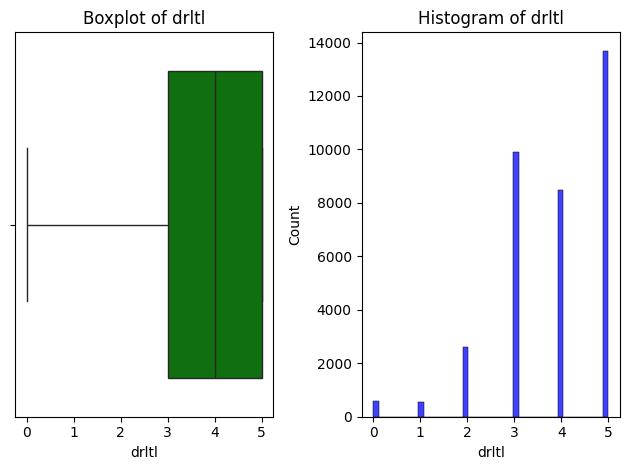

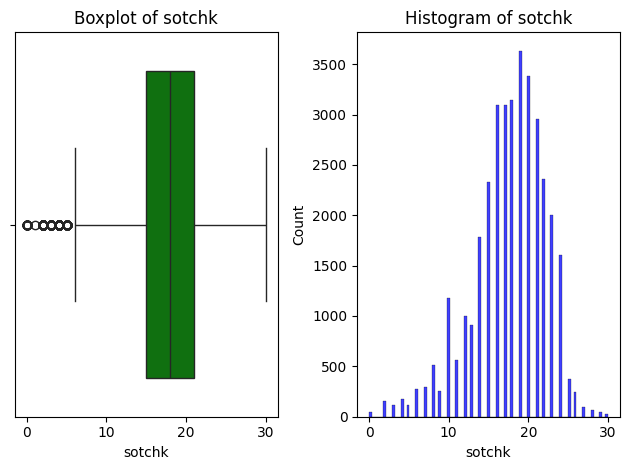

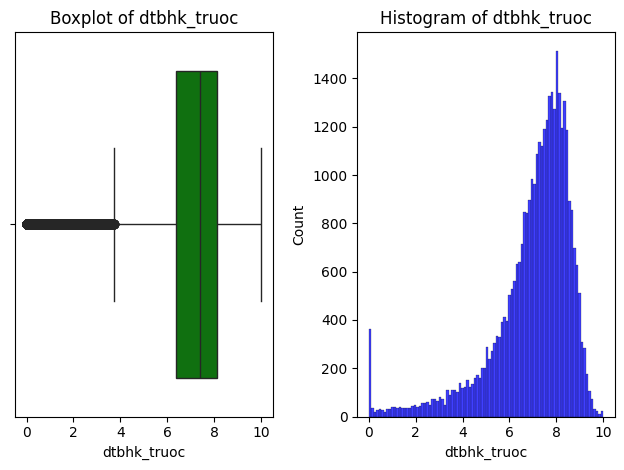

In [20]:
# Tạo hàm vẽ boxplot và histogram
def plots(data, col):
    # Boxplot
    plt.subplot(1, 2, 1)
    sns.boxplot(x=data[col], color='green')
    plt.title(f"Boxplot of {col}")

    # Histogram
    plt.subplot(1, 2, 2)
    sns.histplot(data[col], color='blue')
    plt.title(f"Histogram of {col}")

    plt.tight_layout()
    plt.show()

# Thể hiện biểu đồ
for i in continous_vars:
    plots(df, i)


## Nhận xét 2
- Điểm rèn luyện tích lũy (drltl):

+ Boxplot: Điểm rèn luyện tích lũy chủ yếu tập trung ở mức cao, từ khoảng 3 đến 5. Điều này cho thấy đa phần sinh viên có điểm rèn luyện tích lũy tốt. Không có điểm dữ liệu bất thường hoặc quá thấp, điều này có thể chỉ ra rằng hầu hết sinh viên đạt yêu cầu về mặt rèn luyện.

+ Histogram: Biểu đồ tần suất cho thấy rằng các điểm rèn luyện cao hơn (gần mức 5) phổ biến hơn, với số lượng sinh viên giảm dần khi điểm rèn luyện thấp đi. Điều này có thể cho thấy sự nỗ lực và tính kỷ luật cao trong đa số sinh viên.

- Số tín chỉ học kỳ (sotchk):

+ Boxplot: Có một số điểm ngoại lệ nằm dưới mức tín chỉ bình thường, tuy nhiên phần lớn sinh viên đăng ký từ khoảng 10 đến 30 tín chỉ mỗi học kỳ. Phần đa dữ liệu tập trung ở mức trung bình, cho thấy sinh viên thường có số tín chỉ nằm trong ngưỡng quy định hoặc mong muốn để đảm bảo tiến độ học tập.

+ Histogram: Biểu đồ phân bố có dạng hình chuông, cho thấy rằng phần lớn sinh viên đăng ký một lượng tín chỉ trung bình, với số lượng sinh viên giảm dần khi số tín chỉ quá cao hoặc quá thấp. Điều này có thể gợi ý rằng sinh viên có xu hướng đăng ký số tín chỉ phù hợp với sức học và thời gian.

Do quy định số tín chỉ của hệ đào tạo không vượt quá 30 tín chỉ nên nhóm tiến hành chuyển đổi các giá trị ngoại lai về mức cao nhất (max) là 30

In [21]:
df['sotchk'] = df['sotchk'].apply(lambda x: min(x, 30))

## Phân tích đặc trưng

In [22]:
#Lấy các thuộc tính đã mã hóa
selected_columns = ['gioitinh', 'xl_av', 'xeploai_tt', 'hocky', 'namhoc', 'drltl', 'sotchk',
       'dtbhk_truoc', 'xeploai', 'khuvuc_encoded',
       'namnhaphoc', 'chuyennganh2_encoded', 'hedt_encoded', 'khoahoc',
       'khoa_encoded']

df = df[selected_columns]

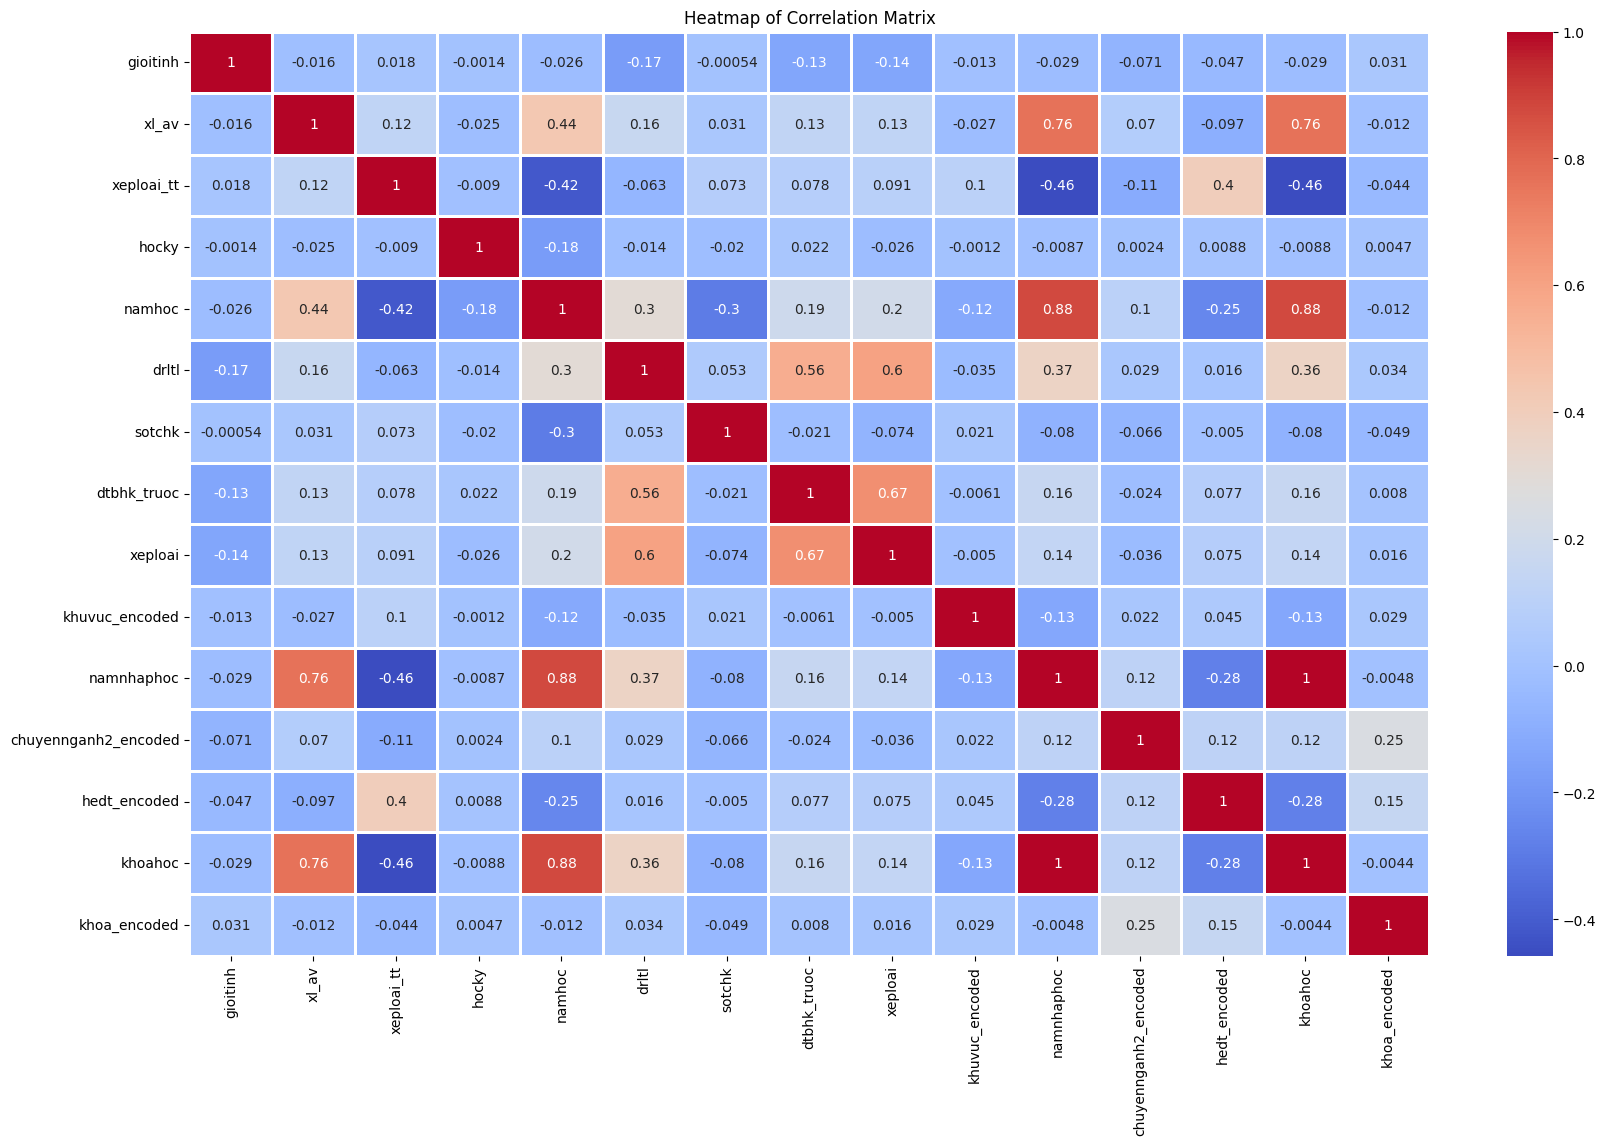

In [23]:
corr = df.corr()

plt.figure(figsize=(20, 12))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=1)
plt.title('Heatmap of Correlation Matrix')
plt.show()

## Nhận xét 3
Nhận thấy thuộc tính khuvuc ảnh hưởng không đáng kể (mức độ tương quan 0.0057) => loại bỏ cột khuvuc

Nhận thấy các thuộc tính đầu vào namhoc, khoahoc, xlav có độ tương quan cao (lớn hơn 0.5) nên nhóm chỉ chọn 1 đặc trưng duy nhất do các thuộc tính dư thừa không đóng góp đáng kể vào khả năng dự đoán đầu ra của mô hình
=> Chọn thuộc tính namhoc

In [24]:
df.drop(['khoahoc', 'xl_av'], axis =1, inplace = True)

# Xuất ra file csv

In [25]:
df.columns

Index(['gioitinh', 'xeploai_tt', 'hocky', 'namhoc', 'drltl', 'sotchk',
       'dtbhk_truoc', 'xeploai', 'khuvuc_encoded', 'namnhaphoc',
       'chuyennganh2_encoded', 'hedt_encoded', 'khoa_encoded'],
      dtype='object')

In [26]:
df.to_csv('/content/drive/MyDrive/Nhóm 3/Bài tập trên lớp/Báo cáo tiến trình/Project/feature_extraction.csv', index = False)